<a href="https://colab.research.google.com/github/Keerthibalraj/Coursera_project/blob/main/Coursera_Project_Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-41lu6tov
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-41lu6tov
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


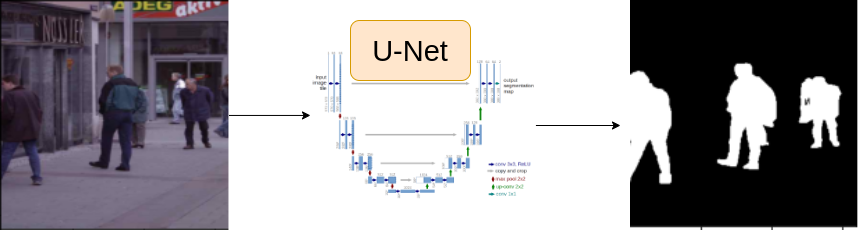

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
csv_file="/content/Human-Segmentation-Dataset-master/train.csv"
data_dir="/content/Human-Segmentation-Dataset-master"

DEVICE='cuda'
epochs=25
lr=0.003
image_size=320
encoder='timm-efficientnet-b0'
weights='imagenet'
BATCH_SIZE=16

In [ ]:
df=pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.iloc[4]
image_path=row.images
mask_path=row.masks

image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

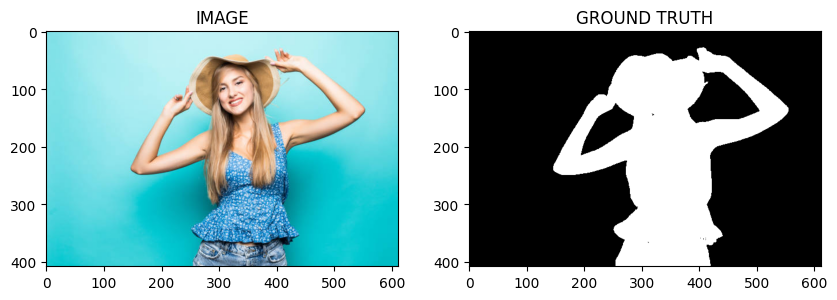

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(image_size,image_size),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
      ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(image_size,image_size),
      ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']
      image=np.transpose(image, (2,0,1)).astype(np.float32)
      mask=np.transpose(mask, (2,0,1)).astype(np.float32)

      image=torch.Tensor(image)/255.0
      mask=torch.round(torch.Tensor(mask)/255.0)
      return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


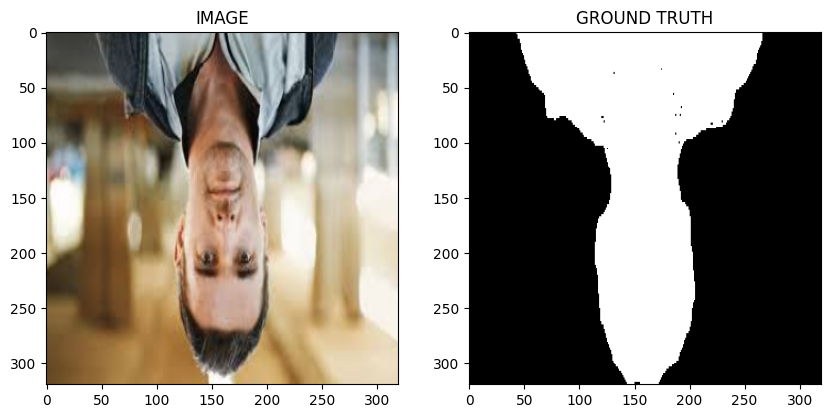

In [ ]:
idx=32

image,mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [ ]:
print(f"NO. of sample in trainloader:{len(trainloader)}")
print(f"NO. of sample in validloader:{len(validloader)}")

NO. of sample in trainloader:15
NO. of sample in validloader:4


In [ ]:
for image, mask in trainloader:
  break
print(f"image shape:{image.shape}")
print(f"mask shape:{mask.shape}")

image shape:torch.Size([16, 3, 320, 320])
mask shape:torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc=smp.Unet(
        encoder_name=encoder,
        encoder_weights=weights,
        in_channels=3,
        classes=1,
        activation=None
    )
  def forward(self, images, masks=None):
    logits=self.arc(images)

    if masks !=None:
      loss1=DiceLoss(mode='binary')(logits, masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1+loss2
    return logits

In [ ]:
model=SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 17.9MB/s]


# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss=0.0
  for images, masks in data_loader:
    images=images.to(DEVICE)
    masks=masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss=model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
  return total_loss/len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
  model.train()
  total_loss=0.0
  with torch.no_grad():
     for images, masks in tqdm(data_loader):
        images=images.to(DEVICE)
        masks=masks.to(DEVICE)
        logists,loss=model(images,masks)
        total_loss+=loss.item()
  return total_loss/len(data_loader)



# Task 8 : Train Model

In [ ]:
optimizer=torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
best_valid_loss=np.Inf
for i in range(epochs):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("BEST_MODEL")
    best_valid_loss=valid_loss
  print(f"Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}")

100%|██████████| 4/4 [00:02<00:00,  1.96it/s]


BEST_MODEL
Epoch: 1 Train_loss: 0.691418049732844 Valid_loss: 0.4596407637000084


100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


BEST_MODEL
Epoch: 2 Train_loss: 0.429108202457428 Valid_loss: 0.442840151488781


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


BEST_MODEL
Epoch: 3 Train_loss: 0.3287130991617839 Valid_loss: 0.37356414645910263


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


BEST_MODEL
Epoch: 4 Train_loss: 0.2702561567227046 Valid_loss: 0.3363604322075844


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


Epoch: 5 Train_loss: 0.2577205538749695 Valid_loss: 0.36072099208831787


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


Epoch: 6 Train_loss: 0.2158870389064153 Valid_loss: 0.33742085099220276


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


Epoch: 7 Train_loss: 0.2015397588411967 Valid_loss: 0.3686261549592018


100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Epoch: 8 Train_loss: 0.24979439278443655 Valid_loss: 0.34789346531033516


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


BEST_MODEL
Epoch: 9 Train_loss: 0.2051496684551239 Valid_loss: 0.30553988367319107


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


BEST_MODEL
Epoch: 10 Train_loss: 0.18477920591831207 Valid_loss: 0.2996530830860138


100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


BEST_MODEL
Epoch: 11 Train_loss: 0.18267013430595397 Valid_loss: 0.29156937822699547


100%|██████████| 4/4 [00:01<00:00,  2.83it/s]


BEST_MODEL
Epoch: 12 Train_loss: 0.21132268607616425 Valid_loss: 0.2901001423597336


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Epoch: 13 Train_loss: 0.16635807702938715 Valid_loss: 0.3706519156694412


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 14 Train_loss: 0.14844692746798197 Valid_loss: 0.3211258314549923


100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


Epoch: 15 Train_loss: 0.15672087371349336 Valid_loss: 0.33766163513064384


100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Epoch: 16 Train_loss: 0.12224547962347666 Valid_loss: 0.30537351220846176


100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


Epoch: 18 Train_loss: 0.11774422576030096 Valid_loss: 0.3046552687883377


100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


Epoch: 19 Train_loss: 0.1394794339934985 Valid_loss: 0.31923574581742287


100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


Epoch: 20 Train_loss: 0.11856617977221807 Valid_loss: 0.30597416684031487


100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


Epoch: 21 Train_loss: 0.12079483518997829 Valid_loss: 0.36410659179091454


100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


BEST_MODEL
Epoch: 22 Train_loss: 0.10109632710615794 Valid_loss: 0.22005013190209866


100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


Epoch: 23 Train_loss: 0.09683749576409657 Valid_loss: 0.26177018135786057


100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


Epoch: 24 Train_loss: 0.09464715793728828 Valid_loss: 0.2347336895763874


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

Epoch: 25 Train_loss: 0.10102476378281912 Valid_loss: 0.25366806983947754


# Task 9 : Inference

In [ ]:
idx=8
model.load_state_dict(torch.load("/content/best_model.pt"))
image,mask=validset[idx]
logits_mask=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

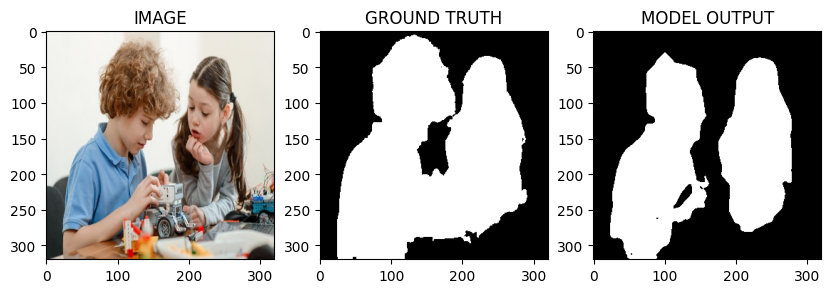

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))